# Bonds 1 

This notebook discusses bond price, interest rates, forward rates, yield to maturity and (as extra material) estimates the yield curve.

## Load Packages and Extra Functions

In [1]:
using Printf, Roots

include("jlFiles/printmat.jl");

In [2]:
using Plots

gr(size=(480,320))
default(fmt = :png)

# Interest Rate vs (Zero Coupon) Bond Price

Zero coupon bonds (also called bills or discount bonds) have very simple cash flows: buy the bond now and get the face value (here normalised to 1) at maturity.

The bond price (for maturity $m$) is a function of the effective interest rate

$B = (1+Y)^{-m}$

and the inverse is $Y = B^{-1/m} - 1$.

Instead, with a continuously compounded interest rate we have 

$B = e^{-m y}$

and $y = -(\ln B)/m$.

These expressions are coded up as short functions in the next cell.

In [3]:
"""
Zero coupon bond/bill price B as a function of Y and m
"""
BillPrice(Y,m) = (1+Y)^(-m)

"""
Effective interest rate Y as a function of B and m
"""
EffRate(B,m)   = B^(-1/m) - 1

"""
Zero coupon bond/bill price B as a function of y and m
"""
BillPrice2(y,m)   = exp(-m*y)

"""
Continuously compounded interest rate y as a function of B and m
"""
ContCompRate(B,m) = -log(B)/m

ContCompRate

Long-maturity bonds are more sensitive to interest rate changes than short-maturity bonds, as illustrated by the plot below.

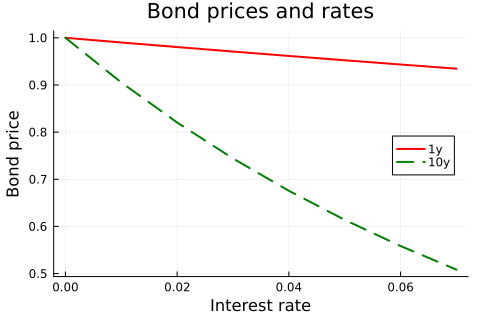

In [4]:
Y_range = 0:0.01:0.07              #different interest rates
B1      = BillPrice.(Y_range,1)    #prices at different interest rates, 1-year zero coupon bond 
B10     = BillPrice.(Y_range,10)   #10-year bond

p1 = plot( Y_range,[B1 B10],
           linecolor = [:red :green],
           linestyle = [:solid :dash],
           linewidth = 2,
           label = ["1y" "10y"],
           legend = :right,
           title = "Bond prices and rates",
           xlabel = "Interest rate",
           ylabel = "Bond price" )
display(p1)

Effective and continuously compounded interest rates are fairly similar at low interest rates, but start to diverge at high rates.

In [5]:
m  = 0.5                              #maturity
B  = 0.95                             #bond price

Y = EffRate(B,m)                      #effective interest rate
y = ContCompRate(B,m)                 #continuously compounded interest rate

printblue("Interest rates ($m-year bond with a price of $B):")
printmat([Y,y];rowNames= ["Effective","Continuously compounded"])

Interest rates (0.5-year bond with a price of 0.95):
Effective                   0.108
Continuously compounded     0.103



# Bond Returns (Zero Coupon Bonds)

Let $B_0$ be the bond price in period $0$ and $B_s$ the price of the same bond $s$ periods later.
The *log* return of holding this bond is 

$r_s = \ln (B_s/B_0)$.

In the computations below, the time to maturity is assumed to be the same in $t=0$ and $t=s$. This is a reasonable approximation if the holding period $s$ are a few days or perhaps weeks, while time to maturity is much longer. Also, the code below lets $B_0$ and $B_s$ be vectors with prices for different maturities.

In [6]:
y₀ = 0.005                      #(continuously compounded) interest rate before
yₛ = 0.015                       #interest rate after  

B₀ = BillPrice2.([y₀ y₀],[1 10])  #bond prices (1-year and 10 year) before, same interest rates
Bₛ = BillPrice2.([yₛ yₛ],[1 10])    #bond prices (1-year and 10 year) after

rₛ = log.(Bₛ./B₀)                 #returns


xy       = vcat([y₀ y₀],B₀,[yₛ yₛ],Bₛ,rₛ)               #to table
rowNames = ["Rate, t=0";"Bond price, t=0";"Rate, t=1";"Bond price, t=1";"Return"]
printblue("Analysis of two bonds: 1y and 10y maturities")
printmat(xy;colNames=["1-year";"10-year"],rowNames=rowNames,width=15,colUnderlineQ=true)

printred("Notice that the return is -m*Δy")

Analysis of two bonds: 1y and 10y maturities
                        1-year        10-year
                        ¯¯¯¯¯¯        ¯¯¯¯¯¯¯
Rate, t=0                0.005          0.005
Bond price, t=0          0.995          0.951
Rate, t=1                0.015          0.015
Bond price, t=1          0.985          0.861
Return                  -0.010         -0.100

Notice that the return is -m*Δy


# Forward Rates

From the forward-spot parity, the forward price of a bond (delivered in $m$ and maturing in $n$) is

$F=\left[  1+Y(m)\right]  ^{m}B(n)=B(n)/B(m)$.

A forward interest rate can then be defined as 

$\Gamma(m,n) = F^{-1/(n-m)} - 1$.

This is a way to lock in the rate for a loan between two future periods ($m$ and $n$).

In [7]:
"""
    ForwardRate(Ym,m,Yn,n)

Calculate late forward rate for the investment period m to n (where m<n).

# Input
- Ym: interest rate for maturity m
- m: maturity m
- Yn: interest rate for maturity n 
- n: maturity n

"""
function ForwardRate(Ym,m,Yn,n)           #forward rate
    (m>=n) && error("m<n is required")
    Bm = (1+Ym)^(-m)
    Bn = (1+Yn)^(-n)
    F  = Bn/Bm
    Γ  = F^(-1/(n-m)) - 1
    return Γ
end

ForwardRate

In [8]:
(m,n,Ym,Yn) = (0.5,0.75,0.04,0.05)

Γ = ForwardRate(Ym,m,Yn,n)
printlnPs("\nImplied forward rate ($m-year -> $n-year): ",Γ)


Implied forward rate (0.5-year -> 0.75-year):      0.070


# Coupon Bond Prices

Recall that a coupon bond price $P$ is the portfolio value

$P = \sum_{k=1}^{K} B(m_k)cf_k$,

where $cf_k$ is the cash flow in period $m_k$ and $B(m_k)$ is the price of a zero-coupon bond maturing in the same period. The last cash flow includes also the payment of the face value.

In [9]:
B  = [0.95,0.9]             #B(1),B(2)
c  = 0.06
cf = [c,1+c]                #cash flows in m=1 and 2

P = sum(B.*cf)

printblue("\n2-year bond with $c coupon:")
rowNames = ["1-year zero coupon bond price","2-year zero coupon bond price","coupon bond price"]
printmat([B;P];rowNames)        #;rowNames is the same as ,rowNames=rowNames


2-year bond with 0.06 coupon:
1-year zero coupon bond price     0.950
2-year zero coupon bond price     0.900
coupon bond price                 1.011



The bond price can also be written

$P = \sum_{k=1}^{K} \frac{cf_{k}}{\left[  1+Y(m_{k})\right]  ^{m_{k}}}$.

The ```BondPrice3()``` function below can handle both the case when $Y$ is a vector with different values for different maturities and when Y is a scalar (same interest rate for all maturities).

In [10]:
"""
    BondPrice3(Y,cf,m)

Calculate bond price as sum of discounted cash flows.

# Input: 
- Y:  scalar or K vector of interest rates
- cf: K vector of cash flows
- m:  K vector of times for the cash flows
"""
function BondPrice3(Y,cf,m)              #cf is a vector of all cash flows at times m
    (length(cf) != length(m)) && error("BondPrice3: cf and m must have the same lengths") 
    cdisc = cf./((1.0.+Y).^m)            #cf1/(1+Y1)^m1, cf2/(1+Y2)^m2 + ...
    P     = sum(cdisc)                   #price
    return P
end

BondPrice3

In [11]:
Y = [0.053,0.054]
c = 0.06
P =  BondPrice3(Y,[c,c+1],[1,2])
printblue("\n2-year bond with $c coupon:")
rowNames = ["1-year spot rate","2-year spot rate","bond price"]
printmat([Y;P];rowNames)

Y = [0.06,0.091]
c = 0.09
P =  BondPrice3(Y,[c,c+1],[1,2])
printblue("\n2-year bond with $c coupon:")
printmat([Y;P];rowNames)


2-year bond with 0.06 coupon:
1-year spot rate     0.053
2-year spot rate     0.054
bond price           1.011


2-year bond with 0.09 coupon:
1-year spot rate     0.060
2-year spot rate     0.091
bond price           1.001



# Yield to Maturity

The yield to maturity (ytm) is the $\theta$ that solves

$P = \sum_{k=1}^{K} \frac{cf_{k}}{(1+\theta)  ^{m_{k}}}$.

We typically have to find $\theta$ by a numerical method.

### A Remark on the Code
- The [Roots.jl](https://github.com/JuliaMath/Roots.jl) package is used to find the ytm.
- The `find_zero(fn,(lower,upper))` finds a root of the function `fn` in the interval `(lower,upper)`.
- The function is here `θ->BondPrice3(θ,cf,m)-P`. This expression creates an anonymous function that takes `θ` as the only argument, and calculates the difference between the price according to `BondPrice3(θ,cf,m)` and `P`. The ytm `θ` makes this zero.

In [12]:
c  = 0.04                  #simple case
Y  = 0.03                  #all spot rates are 3%
m  = [1,2]                 #time of cash flows
cf = [c,c+1]               #cash flows

P = BondPrice3(Y,cf,m)
ytm = find_zero(θ->BondPrice3(θ,cf,m)-P,(-0.1,0.1))   #solving for ytm

printblue("Price and ytm of 2-year $c coupon bond when all spot rates are $Y:")
printmat([P,ytm],rowNames=["price","ytm"])

Price and ytm of 2-year 0.04 coupon bond when all spot rates are 0.03:
price     1.019
ytm       0.030



In [13]:
m  = [1,3]                #cash flow in year 1 and 3
cf = [1,1]                #cash flows
Y  = [0.07,0.10]          #spot interest rates for different maturities

P  = BondPrice3(Y,cf,m)
ytm = find_zero(y->BondPrice3(y,cf,m)-P,(-0.2,0.2))

printblue("'bond' paying 1 in both t=1 and in t=3")
printmat([Y;ytm];rowNames=["1-year spot rate","3-year spot rate","ytm"])

'bond' paying 1 in both t=1 and in t=3
1-year spot rate     0.070
3-year spot rate     0.100
ytm                  0.091



# Bootstrapping (extra)

With information about coupons $c(m)$ and coupon bond price $P(m)$, we solve for the implied zero coupon bond prices $B(s)$ from a system like (here with just 2 maturities)

$$
\begin{bmatrix}
P(1)\\
P(2)
\end{bmatrix} =
\begin{bmatrix}
c(1)+1 & 0 \\
c(2) & c(2)+1
\end{bmatrix}
\begin{bmatrix}
B(1)\\
B(2)
\end{bmatrix}
$$

Notice that each row refers to a specific bond and that each column (in matrix) to different times of cash flows.

### A Remark on the Code

`B = cfMat\P` solves `P = cfMat*B`

In [14]:
c     = [0,0.06]
P     = [0.95,1.01]                 #coupon bond prices
m     = [1,2]                       #time of coupon payments
cfMat = [1    0     ;               #cash flow matrix
         c[2] 1+c[2]]

println("The cash flow matrix")
printmat(cfMat,colNames=["year 1";"year 2"],rowNames=["Bond 1";"Bond 2"],colUnderlineQ=true)

println("B from solving P = cfMat*B (implied zero-coupon bond prices):")
B = cfMat\P
printmat(B,rowNames=["1-year";"2-year"])

Y = EffRate.(B,m)            #solve for the implied spot rates
println("Implied spot interest rates:")
printmat(Y,rowNames=["1-year";"2-year"])

The cash flow matrix
          year 1    year 2
          ¯¯¯¯¯¯    ¯¯¯¯¯¯
Bond 1     1.000     0.000
Bond 2     0.060     1.060

B from solving P = cfMat*B (implied zero-coupon bond prices):
1-year     0.950
2-year     0.899

Implied spot interest rates:
1-year     0.053
2-year     0.055



# Estimating Yield Curve with Regression Analysis (extra)

Recall: with a quadratic discount function

$B(m)=a_{0}+a_{1}m+a_{2}m^{2}$,

we can write the coupon bond price 

$P(m_{K})   =\sum_{k=1}^{K}B(m_{k})c+B(m_{K})$
as 

$P(m_{K})   =\sum_{k=1}^{K}(a_{0}+a_{1}m_{k}+a_{2}m_{k}^{2})c + 
(a_{0}+a_{1}m_{K}+a_{2}m_{K}^{2})$

Collect terms as 

$
P(m_{K})  =a_{0} (Kc+1) +
a_{1}(c \sum_{k=1}^{K} m_{k}+m_{K}) +
a_{2}(c \sum_{k=1}^{K} m_{k}^{2}+m_{K}^{2})$

We estimate $(a_0,a_1,a_2)$ by using the terms (within parentheses) as regressors.

### A Remark on the Code

`a = x\P` solves `P = x*a` if `x` is square, and computes the least-squares solution when `x` is rectangular (as in the cell below).

In [15]:
n = length(P)
x = zeros(n,3)                      #create regressors for quadratic model: 3 columns
for i = 1:n                         #x[i,j] is for bond i, regressor j
    x[i,1] = m[i]*c[i] + 1
    x[i,2] = c[i]*sum(m[1]:m[i]) + m[i]
    x[i,3] = c[i]*sum(abs2,m[1]:m[i]) + m[i]^2    #sum(abs2,x) is the same as sum(x.^2)
end

println("regressors:")
printmat(x,colNames=["term 0";"term 1";"term 2"],rowNames=["Bond 1";"Bond 2"],colUnderlineQ=true)

a = x\P                             #regress P on x
println("regression coefficients")
printmat(a)

m = 1:5
B = [ones(length(m)) m m.^2]*a      #fitted discount function

printmat(B,colNames=["fitted B"],rowNames=string.(m,"-year"))
printred("Btw. do B[4:5] make sense? If not, what does that teach us?\n")

Y = EffRate.(B[1:2],m[1:2])         #solve for the implied spot rates 
printmat(Y,colNames=["fitted Y"],rowNames=string.(m[1:2],"-year"))

regressors:
          term 0    term 1    term 2
          ¯¯¯¯¯¯    ¯¯¯¯¯¯    ¯¯¯¯¯¯
Bond 1     1.000     1.000     1.000
Bond 2     1.120     2.180     4.300

regression coefficients
     0.693
     0.411
    -0.154

        fitted B
1-year     0.950
2-year     0.899
3-year     0.540
4-year    -0.126
5-year    -1.101

Btw. do B[4:5] make sense? If not, what does that teach us?

        fitted Y
1-year     0.053
2-year     0.055

